In [1]:
#Importing Libraries
from music21 import *
import glob
import os
from tqdm import tqdm
import numpy as np
import random
from IPython.display import Image, Audio
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import LSTM, Dense, Input, Dropout
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [2]:
# Function to read and parse MIDI files
def read_files(file):
    notes = []
    try:
        midi = converter.parse(file)
        instrmt = instrument.partitionByInstrument(midi)

        for part in instrmt.parts:
            if 'Piano' in str(part):
                parsing = part.recurse()
                for element in parsing:
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    elif isinstance(element, chord.Chord):
                        notes.append('.'.join(str(n) for n in element.normalOrder))
    except Exception as e:
        print(f"Error parsing {file}: {e}")
    return notes


In [3]:
# Retrieve MIDI file paths
file_path = glob.glob('/kaggle/input/mohamed/*.mid')
notes_array = [read_files(i) for i in file_path]

In [4]:
# Flatten the list of lists to get all notes in one list
sum_notes = sum(notes_array, [])
unique_notes = list(set(sum_notes))
print("Unique Notes:", len(unique_notes))

# Frequency of notes in the dataset
freq = dict(map(lambda x: (x, sum_notes.count(x)), unique_notes))

# Display frequency information for notes
print("\nFrequency notes")
for i in range(30, 100, 20):
    print(i, ":", len(list(filter(lambda x: x[1] >= i, freq.items()))))

# Filter notes based on frequency threshold
freq_notes = dict(filter(lambda x: x[1] >= 10, freq.items()))  # Reduce threshold to 10


# Create a new list of notes based on the filtered notes
new_notes = [[note for note in sequence if note in freq_notes] for sequence in notes_array]

# Create dictionaries for note-to-index and index-to-note mappings
index_to_note = dict(enumerate(freq_notes))
note_to_index = dict(map(reversed, index_to_note.items()))

# Average occurrence of notes in the corpus
def Average(lst):
    return sum(lst) / len(lst)

Occurence = list(freq.values())
print("Average occurrence of a note in the corpus: ", Average(Occurence))


Unique Notes: 237

Frequency notes
30 : 70
50 : 54
70 : 49
90 : 44
Average occurrence of a note in the corpus:  51.143459915611814


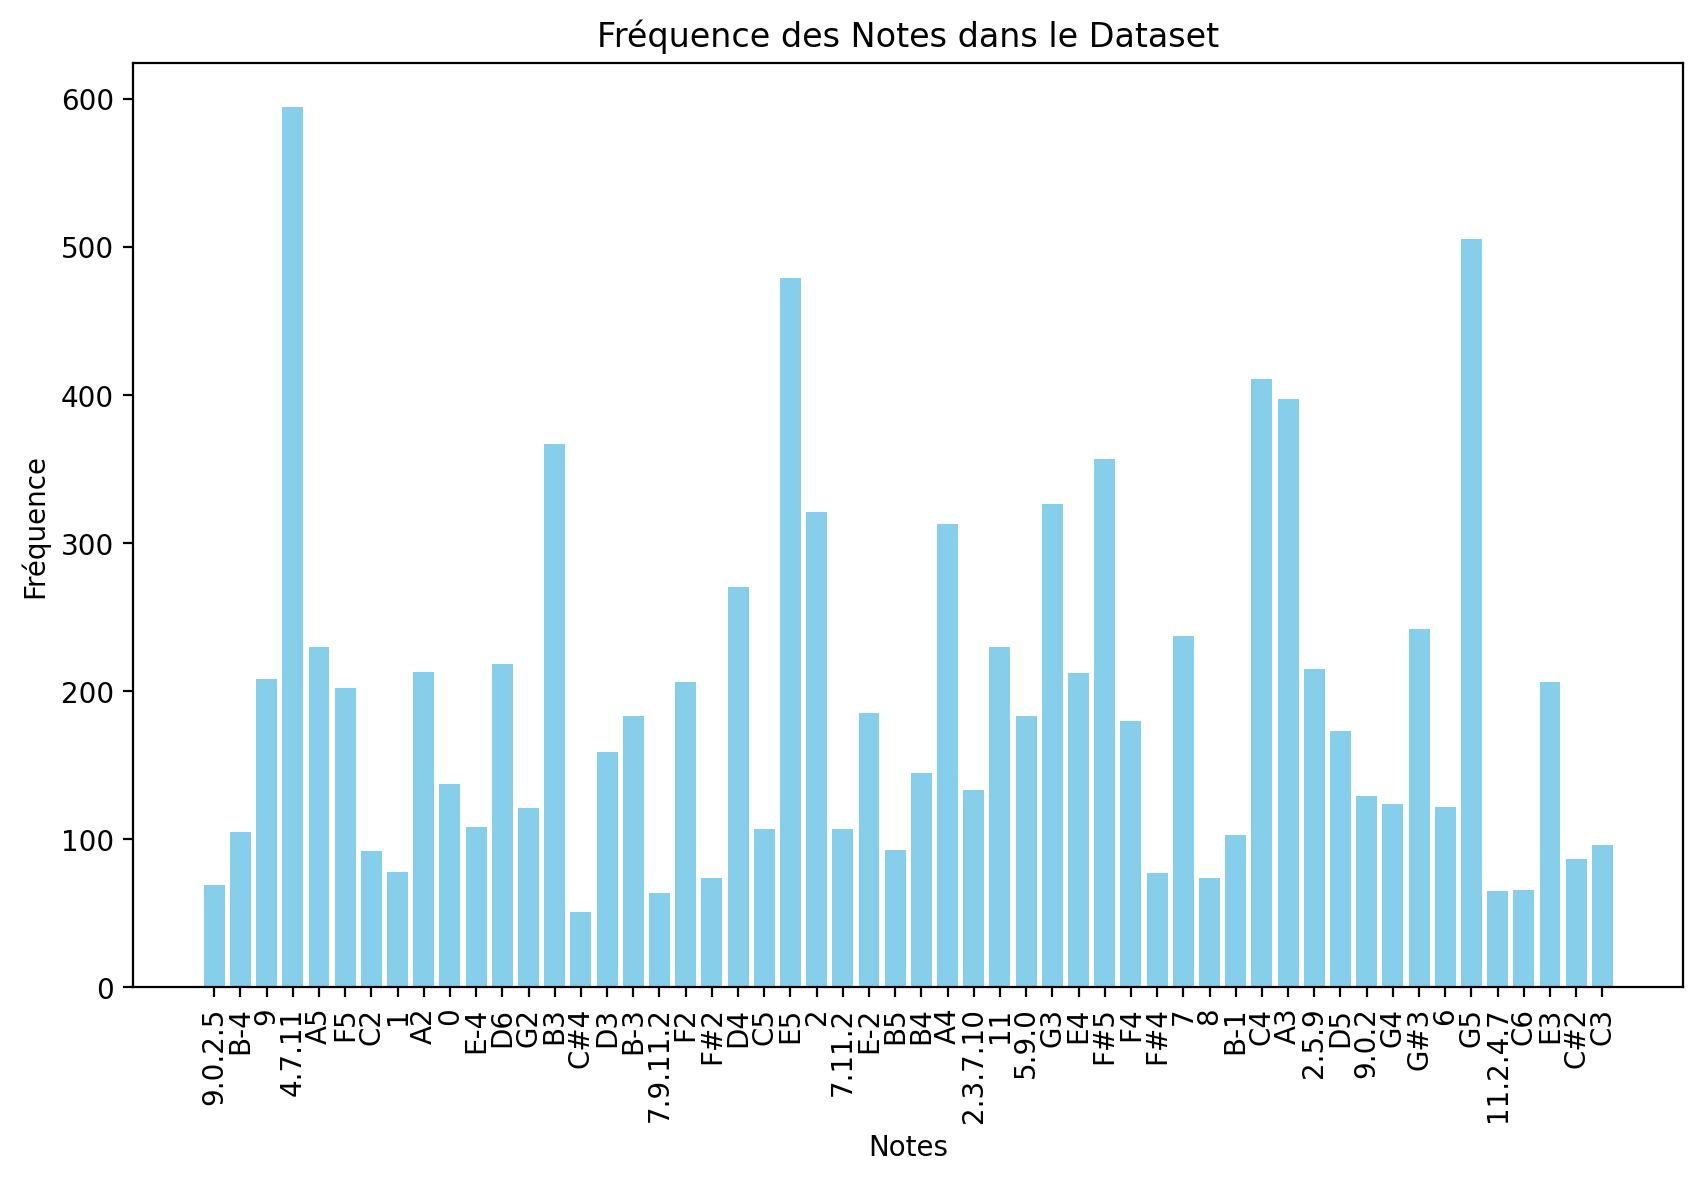

In [6]:
import matplotlib.pyplot as plt

# Distribution des fréquences des notes
freq = dict(map(lambda x: (x, sum_notes.count(x)), unique_notes))
freq_notes = dict(filter(lambda x: x[1] >= 50, freq.items()))

# Visualisation de la distribution
plt.figure(figsize=(10, 6))
plt.bar(freq_notes.keys(), freq_notes.values(), color='skyblue')
plt.xlabel('Notes')
plt.ylabel('Fréquence')
plt.xticks(rotation=90)
plt.title('Fréquence des Notes dans le Dataset')
plt.show()


In [10]:
from tensorflow.keras.utils import to_categorical
# Prepare sequences
timesteps = 50
x, y = [], []
for sequence in new_notes:
    for i in range(len(sequence) - timesteps):
        inp = sequence[i:i + timesteps]
        out = sequence[i + timesteps]
        x.append([note_to_index[n] for n in inp])
        y.append(note_to_index[out])

x_new = np.array(x)
y_new = np.array(y)


y_new = to_categorical(y_new, num_classes=len(note_to_index))

# Reshape input data for LSTM
x_new = np.reshape(x_new, (x_new.shape[0], timesteps, 1))

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2, random_state=42)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Define the model
inputs = Input(shape=(timesteps, 1))

# First LSTM layer with Dropout
x = LSTM(256, return_sequences=True)(inputs)
x = Dropout(0.3)(x)

# Self-Attention layer
attention = tf.keras.layers.Attention()([x, x])
x = LayerNormalization()(attention)

# Second LSTM layer
x = LSTM(256, return_sequences=False)(x)

# Output layer
outputs = Dense(len(note_to_index), activation="softmax")(x)

# Compile the model
model = Model(inputs, outputs)
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])



In [12]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[reduce_lr, early_stop]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 50, 256)        │        264,192 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 256)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 50, 256)        │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 50, 256)        │            512 │ attention[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 107)            │         27,499 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 817,515 (3.12 MB)

 Trainable params: 817,515 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1214 - loss: 3.8970 - val_accuracy: 0.1788 - val_loss: 3.0927 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2924 - loss: 2.8119 - val_accuracy: 0.4470 - val_loss: 2.2142 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4901 - loss: 1.9990 - val_accuracy: 0.5468 - val_loss: 1.8287 - learning_rate: 0.0010
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5919 - loss: 1.5855 - val_accuracy: 0.6372 - val_loss: 1.4899 - learning_rate: 0.0010
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6261 - loss: 1.4195 - val_accuracy: 0.6613 - val_loss: 1.3143 - learning_rate: 0.0010
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6883 - loss: 1.1776 - val_accuracy: 0.6887 - val_loss: 1.2134 - learning_rate: 0.0010
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7180 - loss: 1.

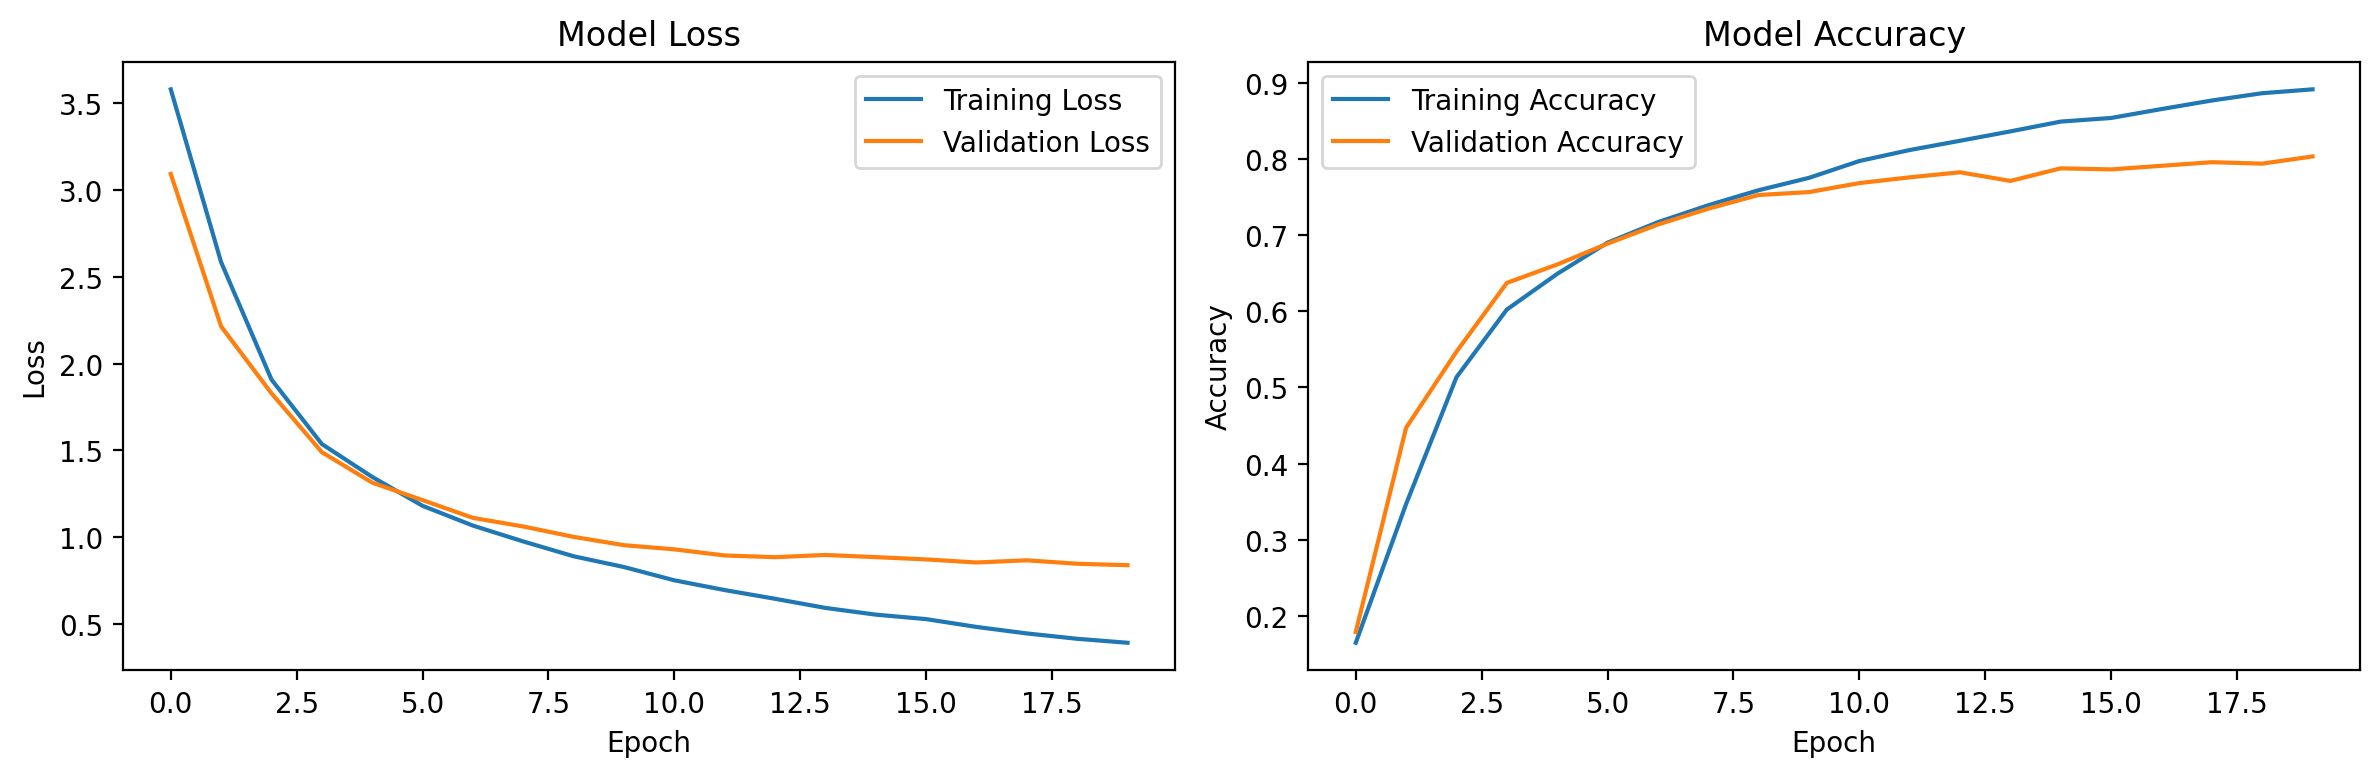

In [13]:
# Visualize training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7986 - loss: 0.8458
Test Loss: 0.8386789560317993
Test Accuracy: 0.8032166361808777


In [16]:
def generate_notes(model, seed, note_to_index, index_to_note, timesteps=50, num_notes=500):
    # Convert the seed sequence to a list of indices (flatten if necessary)
    generated_notes = list(seed.flatten())  # Ensure it's a list of scalar values
    
    for _ in range(num_notes):
        # Prepare input for prediction
        input_sequence = np.array(generated_notes[-timesteps:])  # Get the last 'timesteps' notes
        input_sequence = np.reshape(input_sequence, (1, timesteps, 1))  # Reshape to (1, timesteps, 1)
        
        # Predict the next note
        predicted_probabilities = model.predict(input_sequence, verbose=0)
        predicted_index = np.argmax(predicted_probabilities)
        
        # Append the predicted note to the sequence
        generated_notes.append(predicted_index)
    
    # Convert the generated indices back to notes
    generated_notes = [index_to_note[i] for i in generated_notes]
    return generated_notes


In [17]:

seed_sequence = x_train[0] 
generated_sequence = generate_notes(model, seed_sequence, note_to_index, index_to_note)
print(generated_sequence)


['G4', 'C4', 'D4', 'E4', 'G3', 'D4', 'C4', 'G2', '7.9.2', 'G3', 'D4', 'A3', 'B3', 'G2', 'G3', 'D4', 'B3', 'D3', 'A3', 'G3', 'D3', 'G2', 'D3', 'D4', 'G3', 'A3', 'D3', 'G2', 'D3', 'D4', 'G3', 'A3', 'B3', 'D3', 'A3', 'G3', 'E3', 'B3', '4.6.11', '4.6.11', 'E3', 'B3', '4.6.11', '4.6.11', 'B3', '4.6.11', 'A2', 'E3', 'E4', 'A3', 'B3', '4.6.11', '4.6.11', 'B3', '4.6.11', 'B3', 'E3', 'A2', 'E3', 'A2', 'E3', 'A2', 'E3', 'A2', 'E3', 'A2', 'A3', 'A2', 'A3', 'G3', 'B3', 'C3', 'B3', 'E3', 'A2', 'E3', 'A2', 'C3', 'G3', 'G4', 'E4', 'E3', 'G3', 'G3', 'E3', 'G3', 'G3', 'E3', 'G3', 'G3', 'G3', 'D4', 'C4', 'D4', 'C4', 'D4', 'C4', 'C3', 'D4', 'G3', 'C3', 'D4', 'C4', 'C3', 'D4', 'E4', 'C3', 'C4', 'E4', 'E3', 'C4', 'C4', 'C4', 'D4', 'C4', 'C4', 'C4', 'C4', 'E4', 'E4', 'A3', 'C4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '9.1.4', '7.11.2', '7.11.2', 'F#4', 'B4', 'E5', 'F#4', 'B4', '2.6.9', 'B3', 'B3', 'B3', 'B3', '2.5.9', '2.5.9', '2.

In [18]:
from music21 import stream, note, chord, duration

def create_midi_from_notes(generated_notes, output_file="generated_music.mid", note_duration=0.5):
    """Converts a sequence of notes and chords into a MIDI file with reduced duration."""
    midi_stream = stream.Stream()

    for item in generated_notes:
        if '.' in item or item.isdigit():  # Chord
            chord_notes = [note.Note(int(n)) for n in item.split('.')]
            new_chord = chord.Chord(chord_notes)
            new_chord.duration = duration.Duration(note_duration)
            midi_stream.append(new_chord)
        else:  # Single note
            new_note = note.Note(item)
            new_note.duration = duration.Duration(note_duration)
            midi_stream.append(new_note)

    # Write the stream to a MIDI file
    midi_stream.write("midi", fp=output_file)
    print(f"MIDI file saved as {output_file}")


In [19]:
# Generate a sequence of notes
seed_sequence = x_train[0]  # First sequence from the training set
generated_sequence = generate_notes(model, seed_sequence, note_to_index, index_to_note)

# Convert the generated sequence to a MIDI file
create_midi_from_notes(generated_sequence, output_file="generated_music.mid")


MIDI file saved as generated_music.mid


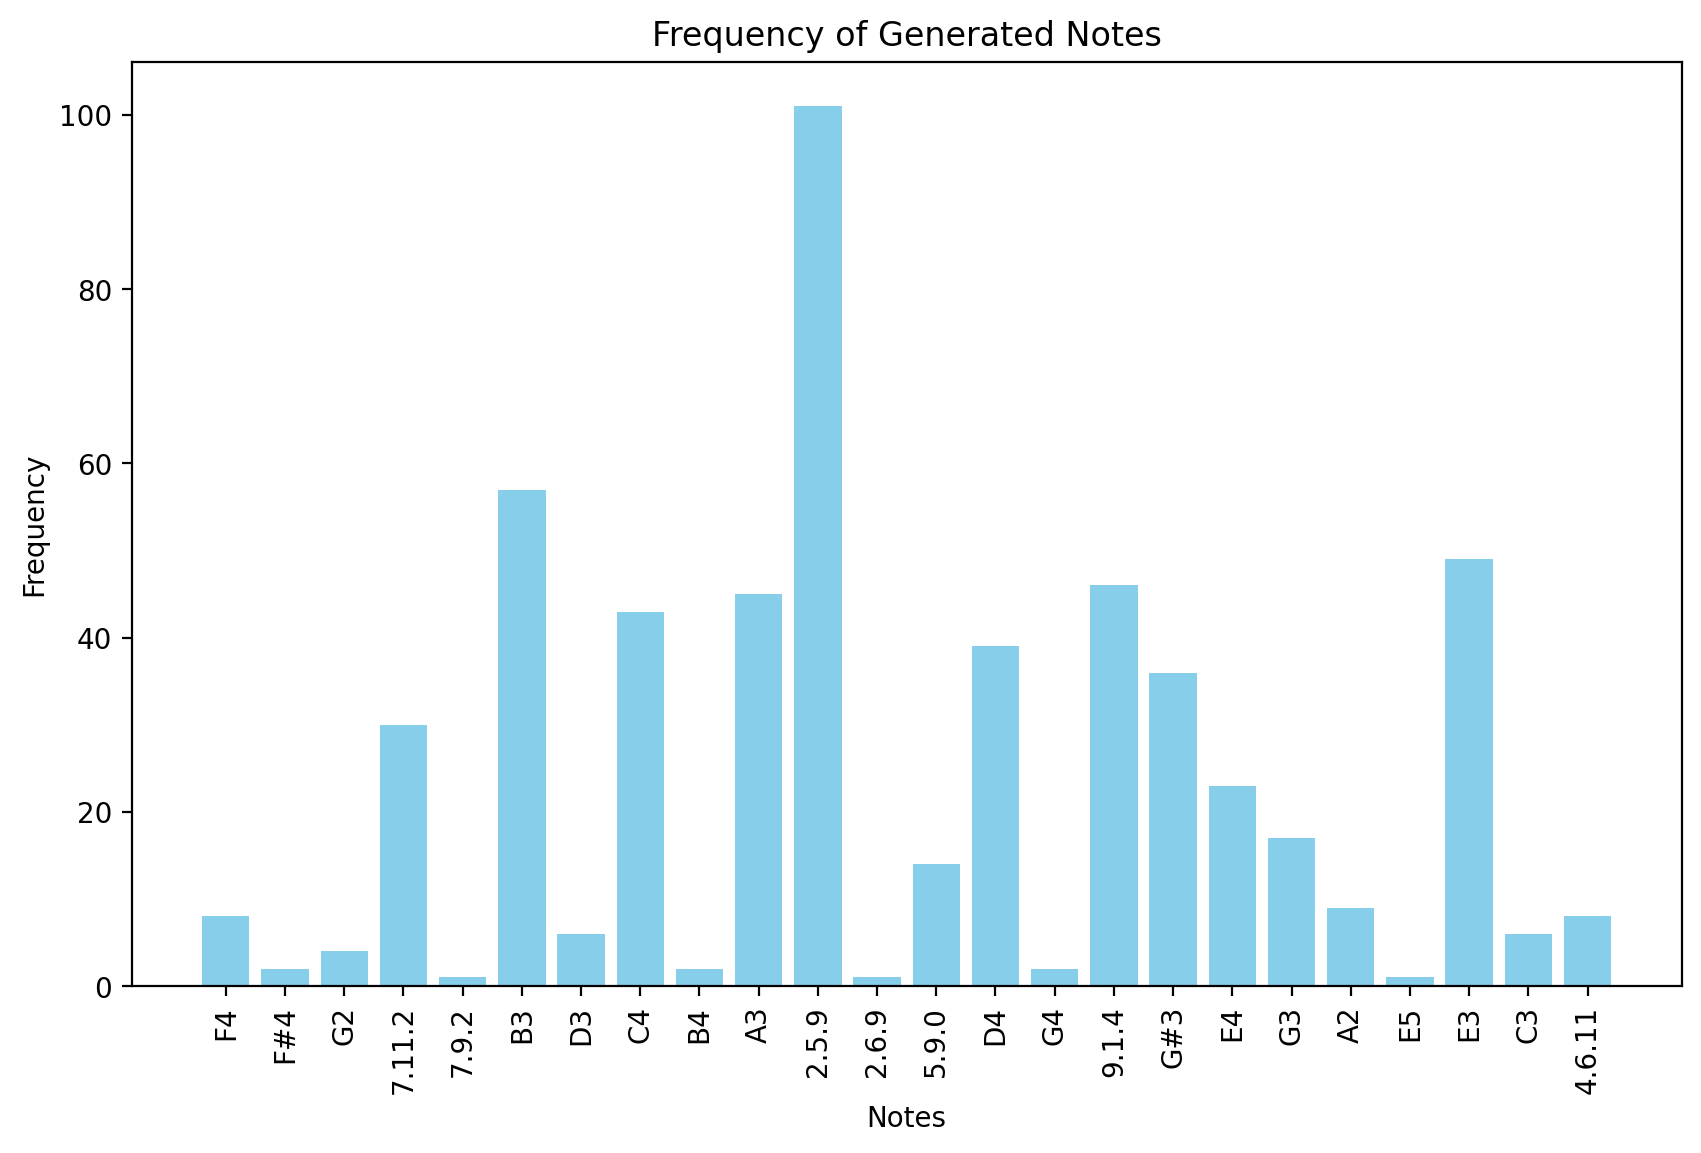

In [23]:
import matplotlib.pyplot as plt

def visualize_notes(note_sequence):
    """Visualizes the frequency of notes in the generated sequence."""
    unique_notes = list(set(note_sequence))
    note_counts = [note_sequence.count(note) for note in unique_notes]

    plt.figure(figsize=(10, 6))
    plt.bar(unique_notes, note_counts, color='skyblue')
    plt.xlabel('Notes')
    plt.ylabel('Frequency')
    plt.title('Frequency of Generated Notes')
    plt.xticks(rotation=90)
    plt.show()

# Visualize the generated notes
visualize_notes(generated_sequence)


In [24]:
from music21 import *
# Load the MIDI file
mf = converter.parse('generated_music.mid')
# Check the contents in more detail
print("Number of elements:", len(mf.elements))
print("Instruments in the stream:", mf.getInstruments())
# Try to stream the MIDI
mf.show('midi') # This might open the default MIDI player

Number of elements: 2
Instruments in the stream: <music21.stream.Score 0x7f41c9f838e0>
